#  20.프로젝트 : GQA 모델 활용하기
## LXMERT

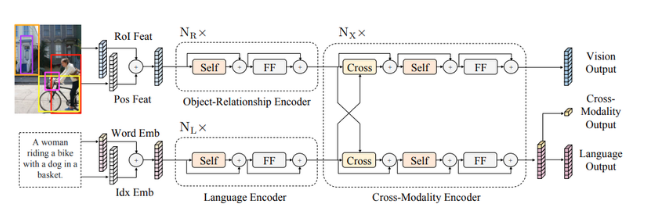

LXMERT는 3개의 Pretrained Encoder로 구성된다. 하지만 Encoder 앞에 이미지 feature를 추출하기 위한 F-RCNN 계열의 모델이 붙어 있고, 텍스트 feature(Embedding)를 추출하기 위한 Tokenizer 및 전처리 단계 등이 붙어 있다. Multimodal pretraining을 위해서 5가지나 되는 training task가 수행되어야 하기 때문에 모델 출력부도 매우 복잡하다.



## GQA 모델 활용하기
### 환경 설정

>참고    
Huggingface의 LXMERT 예제코드를 참조, 파이토치(PYTORCH) 이용

torch 설치
- 참고: [pytorch](https://pytorch.org/get-started/locally/)

```python
$ pip3 install torch torchvision torchaudio
# torch설치 완료 후, 재부팅하세요.
# 재부팅 명령어입니다!!
$ sudo reboot
```

### 소스코드로 접근하는 Huggingface
```python
$ pip uninstall transformers
$ cd ~/aiffel
$ git clone https://github.com/huggingface/transformers.git
$ cd transformers
$ pip install -e .
```

transformers 프로젝트 디렉토리 하위에 10개가 넘는 서브디렉토리가 있다. 살펴보게 될 코드들은 ```src/transformers``` 아래의 메인 프로젝트 부분과 ```examples/resear h_projects/lxmert``` 아래의 예제코드들이다.

예제코드에 필요한 dependency 설치를 위해 아래를 실행한다.

```python
$ pip install -r ~/aiffel/transformers/examples/research_projects/lxmert/requirements.txt
```
### STEP 1. 다른 이미지 테스트해 보기
앞서 실습해 본 LXMERT 모델 활용법을 다른 이미지를 통해서도 한번 시도하고 결과를 확인해 봅시다.

- F-RCNN 모델을 이용해 새로운 URL로 주어진 이미지에 대해 bounding box를 그려 봅시다.
- test_questions_for_url2에 주어진 질문에 대한 답을 찾아봅시다.

In [1]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

1.8.1+cu102


- pretrained model인 LXMERT를 사용하기 위해 텍스트의 dictionary와 이미지에 등장하는 object, attribute에 대한 사전 정의가 필요하다. LXMERT 원저자들이 제공한 사전정보를 살펴본다. 

In [2]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL) # utils.get_data(): URL에 게시된 json 형태의 데이터를 파싱해 list로 변환
print(len(objids))
print(objids[:30])  #1600개의 단어사전 중 30개만 출력

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [3]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [4]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


- object와  attribute의 차이

VQA2 데이터셋의 정의를 보면 ```cup is white```라는 문장이 있다면 주어인 cup애 object, 술부의 white가 attribute이다. 

- VQA answer 

VQA 퀴즈를 풀었을 때 답이 될 수 있는 것의 모임이다. 3129개의 정답 중 가장 확률이 높은 한 가지를 선택하는 분류 문제로 바꾸었다. 

- 이미지 입력 데이터

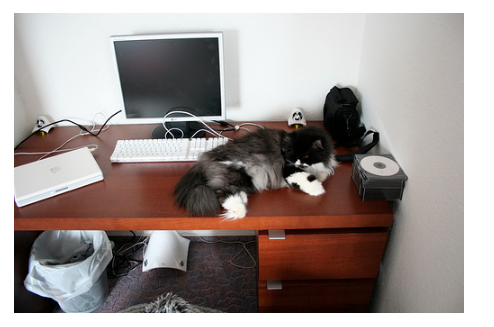

```Preprocess```라는 전처리 클래스를 통해 이미지 피처링용 F-RCNN 모델에 입력할 데이터로 가공한다. 이 전처리 클래스는 ```processing_image.py```에 포함되어 있다.

In [5]:
# 위 이미지의 URL
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)  # 전처리 클래스

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [6]:
print(images)
print("image size:", sizes)

tensor([[[[  61.0199,   61.2689,   62.1015,  ...,   50.5607,   50.1444,
             50.0199],
          [  60.8955,   61.1445,   61.9771,  ...,   50.8094,   50.3931,
             50.2686],
          [  60.4793,   60.7282,   61.5609,  ...,   51.6420,   51.2256,
             51.1012],
          ...,
          [ -87.9801,  -88.0373,  -88.2285,  ...,   21.7716,   21.5466,
             21.4793],
          [ -87.9801,  -88.0891,  -88.4536,  ...,   21.9628,   21.9110,
             21.8955],
          [ -87.9801,  -88.1046,  -88.5209,  ...,   22.0199,   22.0199,
             22.0199]],

         [[  48.0535,   48.4269,   49.6759,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.9291,   48.2871,   49.4843,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.5129,   47.8190,   48.8429,  ...,   41.5943,   41.1780,
             41.0535],
          ...,
          [ -99.9465,  -99.9364,  -99.9026,  ...,   13.8052,   13.5802,
             13.5129],
          [ -99.94

In [7]:
# 질문 텍스트 입력

test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

### F-RCNN 구성
#### F-RCNN을 활용한 이미지 피처링

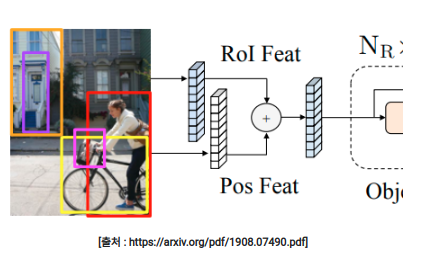

VQA에서 이미지 입력을 피처로 추출할 때 Object Detection 모델을 활용해 ROI나 POS feature를 활용하는 것이 일반적이다. Huggingface는 F-RCNN 모델이 제공하는 Model 및 configuration이 존재한다. 그러나 모델 자체는 LXMERT 모델 영역 외부이다. 그래서 F-RCNN을 활용하기 위한 코드를 modeling_frcnn.py에 제공하였다.

In [8]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj44/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [9]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

모델이 생성되었다. 위에서 전처리되어 얻어진 입력값을 생성된 모델에 입력한다.

In [10]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

```output_dict```에 F-RCNN의 출력값이 저장된다.

In [11]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.0372e+02, 1.3613e+02, 2.2735e+02, 1.6974e+02],
         [8.4005e+01, 1.1941e+02, 2.4814e+02, 1.7585e+02],
         [0.0000e+00, 8.1354e+01, 3.2642e+02, 2.6568e+02],
         [3.8475e+02, 3.7221e+01, 4.9974e+02, 3.3300e+02],
         [2.9875e+01, 0.0000e+00, 4.3054e+02, 1.3465e+02],
         [1.5929e+02, 9.1682e+01, 3.7275e+02, 2.4955e+02],
         [6.7672e-01, 2.4750e+02, 2.7701e+02, 3.3300e+02],
         [1.6578e+02, 1.2526e+02, 3.4723e+02, 2.1946e+02],
         [0.0000e+00, 7.1275e+01, 2.1836e+02, 3.0790e+02],
         [5.2669e+01, 1.7062e+00, 2.6646e+02, 1.8314e+02],
         [6.1805e+01, 2.4761e+02, 4.2838e+02, 3.3299e+02],
         [1.2076e+01, 1.1892e+02, 3.6657e+02, 3.0462e+02],
         [1.9641e+02, 1.0624e+02, 3.5971e+02, 1.9710e+02],
         [9.1356e+01, 1.1064e+02, 4.1889e+02, 2.8040e+02],
         [1.2139e+02, 1.0626e+01, 4.8306e+02, 1.6577e+02],
         [3.0271e+02, 1.0307e+02, 3.2805e+02, 1.2879e+02],
         [2.9658e+02, 5.5949e+00, 4.9991e+02, 2.7482e+02

36개의 box 정보가 있음을 알 수 있다. LXMERT의 입력으로 활용될 ROI feature를 추출한다. 

In [12]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])
-------------
torch.Size([1, 36, 2048])


bounding box 좌푯값 등 대부분의 값이 0~1 사이의 소수로 이루어져 있다. 좌푯값 등이 전처리 단계에서 전체 이미지 width, height 를 1로 했을 때의 기준으로 normalize된 수치이다.

시각화를 통해 실제로 object detection이 이미지를 잘 분석하고 있는지 확인하자.

시각화를 위해 제공된 ```visualizing_image.py```에 포함된 ```SingleImageViz 클래스```를 활용한다.

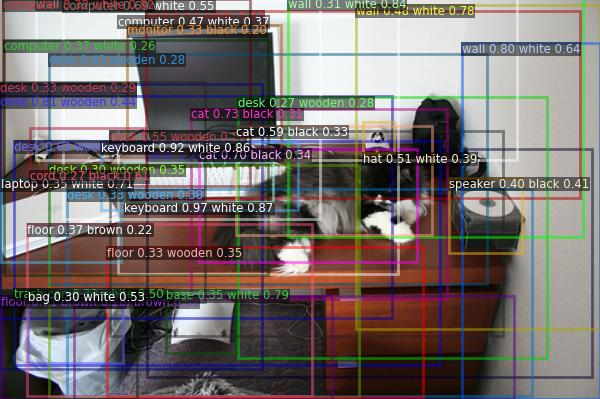

In [13]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))  # np.unit8(): 양수, 0-255, np.clip(): array 내 원소가 범위 외의 크기이면 범위값으로 바꿔줌
    f = io.BytesIO() # 바이너리 I/O, bytes 객체 생성. 텍스트가 아닌 데이터에 사용
    PIL.Image.fromarray(a).save(f, fmt) # numpy 배열을 PIL 이미지로 변환
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

36개의 검출된 bounding box 상단에 object 정보와 attribute 정보 및 확률값이 시각화되었다. 이제 모델에 입력할 feature를 아래와 같이 추출한다.

In [14]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [15]:
normalized_boxes

tensor([[[2.0743e-01, 4.0880e-01, 4.5471e-01, 5.0972e-01],
         [1.6801e-01, 3.5860e-01, 4.9628e-01, 5.2809e-01],
         [0.0000e+00, 2.4431e-01, 6.5283e-01, 7.9785e-01],
         [7.6949e-01, 1.1178e-01, 9.9947e-01, 1.0000e+00],
         [5.9750e-02, 0.0000e+00, 8.6108e-01, 4.0435e-01],
         [3.1857e-01, 2.7532e-01, 7.4550e-01, 7.4938e-01],
         [1.3534e-03, 7.4325e-01, 5.5402e-01, 1.0000e+00],
         [3.3155e-01, 3.7617e-01, 6.9447e-01, 6.5903e-01],
         [0.0000e+00, 2.1404e-01, 4.3671e-01, 9.2462e-01],
         [1.0534e-01, 5.1236e-03, 5.3291e-01, 5.4997e-01],
         [1.2361e-01, 7.4356e-01, 8.5676e-01, 9.9998e-01],
         [2.4152e-02, 3.5711e-01, 7.3314e-01, 9.1477e-01],
         [3.9282e-01, 3.1905e-01, 7.1942e-01, 5.9188e-01],
         [1.8271e-01, 3.3226e-01, 8.3777e-01, 8.4205e-01],
         [2.4278e-01, 3.1911e-02, 9.6612e-01, 4.9782e-01],
         [6.0542e-01, 3.0951e-01, 6.5611e-01, 3.8676e-01],
         [5.9316e-01, 1.6801e-02, 9.9982e-01, 8.2528e-01

In [16]:
features

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])

## 20-4. 모델 구성(2) LxmertTokenizer
### LXMERT의 tokenizer 활용

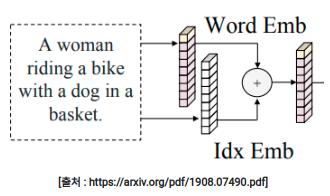

In [17]:
# Huggingface에서 제공하는 LXMERT의 tokenizer 생성
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [18]:
test_question = ["Where is the cat?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [19]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2073, 2003, 1996, 4937, 1029,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


LXMERT 논문에서는 embedding 부분은 모델 밖의 featuring 영역으로 규정하고 있지만, 실제 구현 상으로는 Tokenizer까지만 모델 밖으로 두고, 이후 Embedding부터는 모델 내부의 레이어로 처리하고 있다. 

## 20-5. 모델 구성(3) LxmertModel
### LXMERT pretrained model 활용
모델을 구동해 보고 출력부 형태의 파악해본 후 모델 내부구조를 살펴본다.

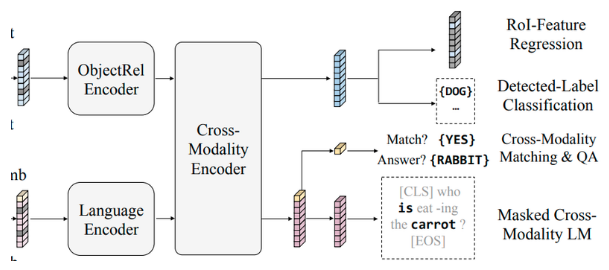

In [20]:
# 모델 생성
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [21]:
# feature를 활용해 모델 구동
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-3.0494, -0.2973,  2.2342,  ...,  0.0078,  2.1437,  0.1003]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

```question_answering_score```라는 항목에만 의미 있는 값이 나오고, 그 외 대부분의 항목은 None이다. 이는 ```LxmertForQuestionAnswering```이라는 모델이 LXMERT 모델 파라미터를 활용해서 VQA 문제에 대한 답만 inference하는 모델이었기 때문이다. 만약 우리가 5개의 task를 풀어야 하는 pretrain용 모델을 활용했다면 같은 파라미터를 가지고도 훨씬 다양한 output을 출력했을 것이다.

In [22]:
len(output_vqa["question_answering_score"][0])

3129

입력부의 결과와 같이 ```question_answering_score```3129가지 answer dictionary에 대한 각각의 score이며, 이 score가 가장 높은 것이 답이다.

In [23]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([2534])

In [24]:
vqa_answers[2534]

'desk'

In [25]:
# 정답인지 확인
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk


In [26]:
for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: cat
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black and white
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: rectangle
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white




### STEP 2. GQA 데이터셋 버전 모델 테스트해 보기
이전 노드에서 소개했던 VQA를 위한 다양한 데이터셋 중에  [GQA](https://cs.stanford.edu/people/dorarad/gqa/index.html)라는 것이 있었습니다. 이 데이터셋은 scene graph라는 것을 활용해서 object간 관계를 더욱 명확하게 학습할 수 있도록 한 것입니다.

지금까지 사용했던 모델은 VQA2 데이터셋을 활용해 학습시킨 모델이었습니다. Huggingface에서는 동일한 모델 구조를 활용해 GQA로 학습시킨 모델을 함께 제공하고 있습니다. 아래 정보를 활용해 위 STEP 1. 에서 테스트했던 이미지에 대해 동일하게 테스트해 봅시다.

In [27]:
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"


gqa_answers = utils.get_data(GQA_URL)
print(len(gqa_answers))
print(gqa_answers[:30])  #1842개의 단어사전 중 30개만 출력


1842
['cat food', 'elephant', 'gloves', 'football', 'dock', 'shops', 'water', 'light blue', 'chair', 'players', 'tourist', 'magnet', 'railroad', 'ski lift', 'mirror', 'leggings', 'hurdle', 'shuttle', 'wildflowers', 'flowers', 'cooking pot', 'pipe', 'swan', 'girl', 'celery', 'brown', 'ambulance', 'steps', 'power line', 'asphalt']


In [28]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [29]:
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [30]:
for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: can
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: square
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


### STEP 3. 내가 선택한 이미지로 VQA/GQA 버전 비교해 보기
- 이번에는 여러분들이 임의로 이미지를 하나 골라 봅시다.
- 이미지에 대해 3~5가지 정도 영어로 질문을 작성해 봅시다.
- STEP 1, 2에서 수행했던 내용을 본인이 고른 이미지에 대해 동일하게 수행하고, 결과를 비교해 봅시다.

In [31]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL) 

# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)


In [32]:
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)

In [33]:
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
gqa_answers = utils.get_data(GQA_URL)

In [37]:
URL = "https://media.architecturaldigest.com/photos/5bbf6eded249622e01c31366/16:9/w_2560%2Cc_limit/AD110118_WELL60_01.jpg"
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)  # 전처리 클래스

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [75]:
test_questions_for_url2 = [
    "Where is the woman?",
    "What is near the table?",
    "What is the color of the lamp?",
    "What is the shape of the window?",
    "What is the color of the curtain?",
    "What is the baby doing?",
    "Where is the jar?"
    ]

In [67]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

frcnn_cfg.max_detections 

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj44/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


36

In [68]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

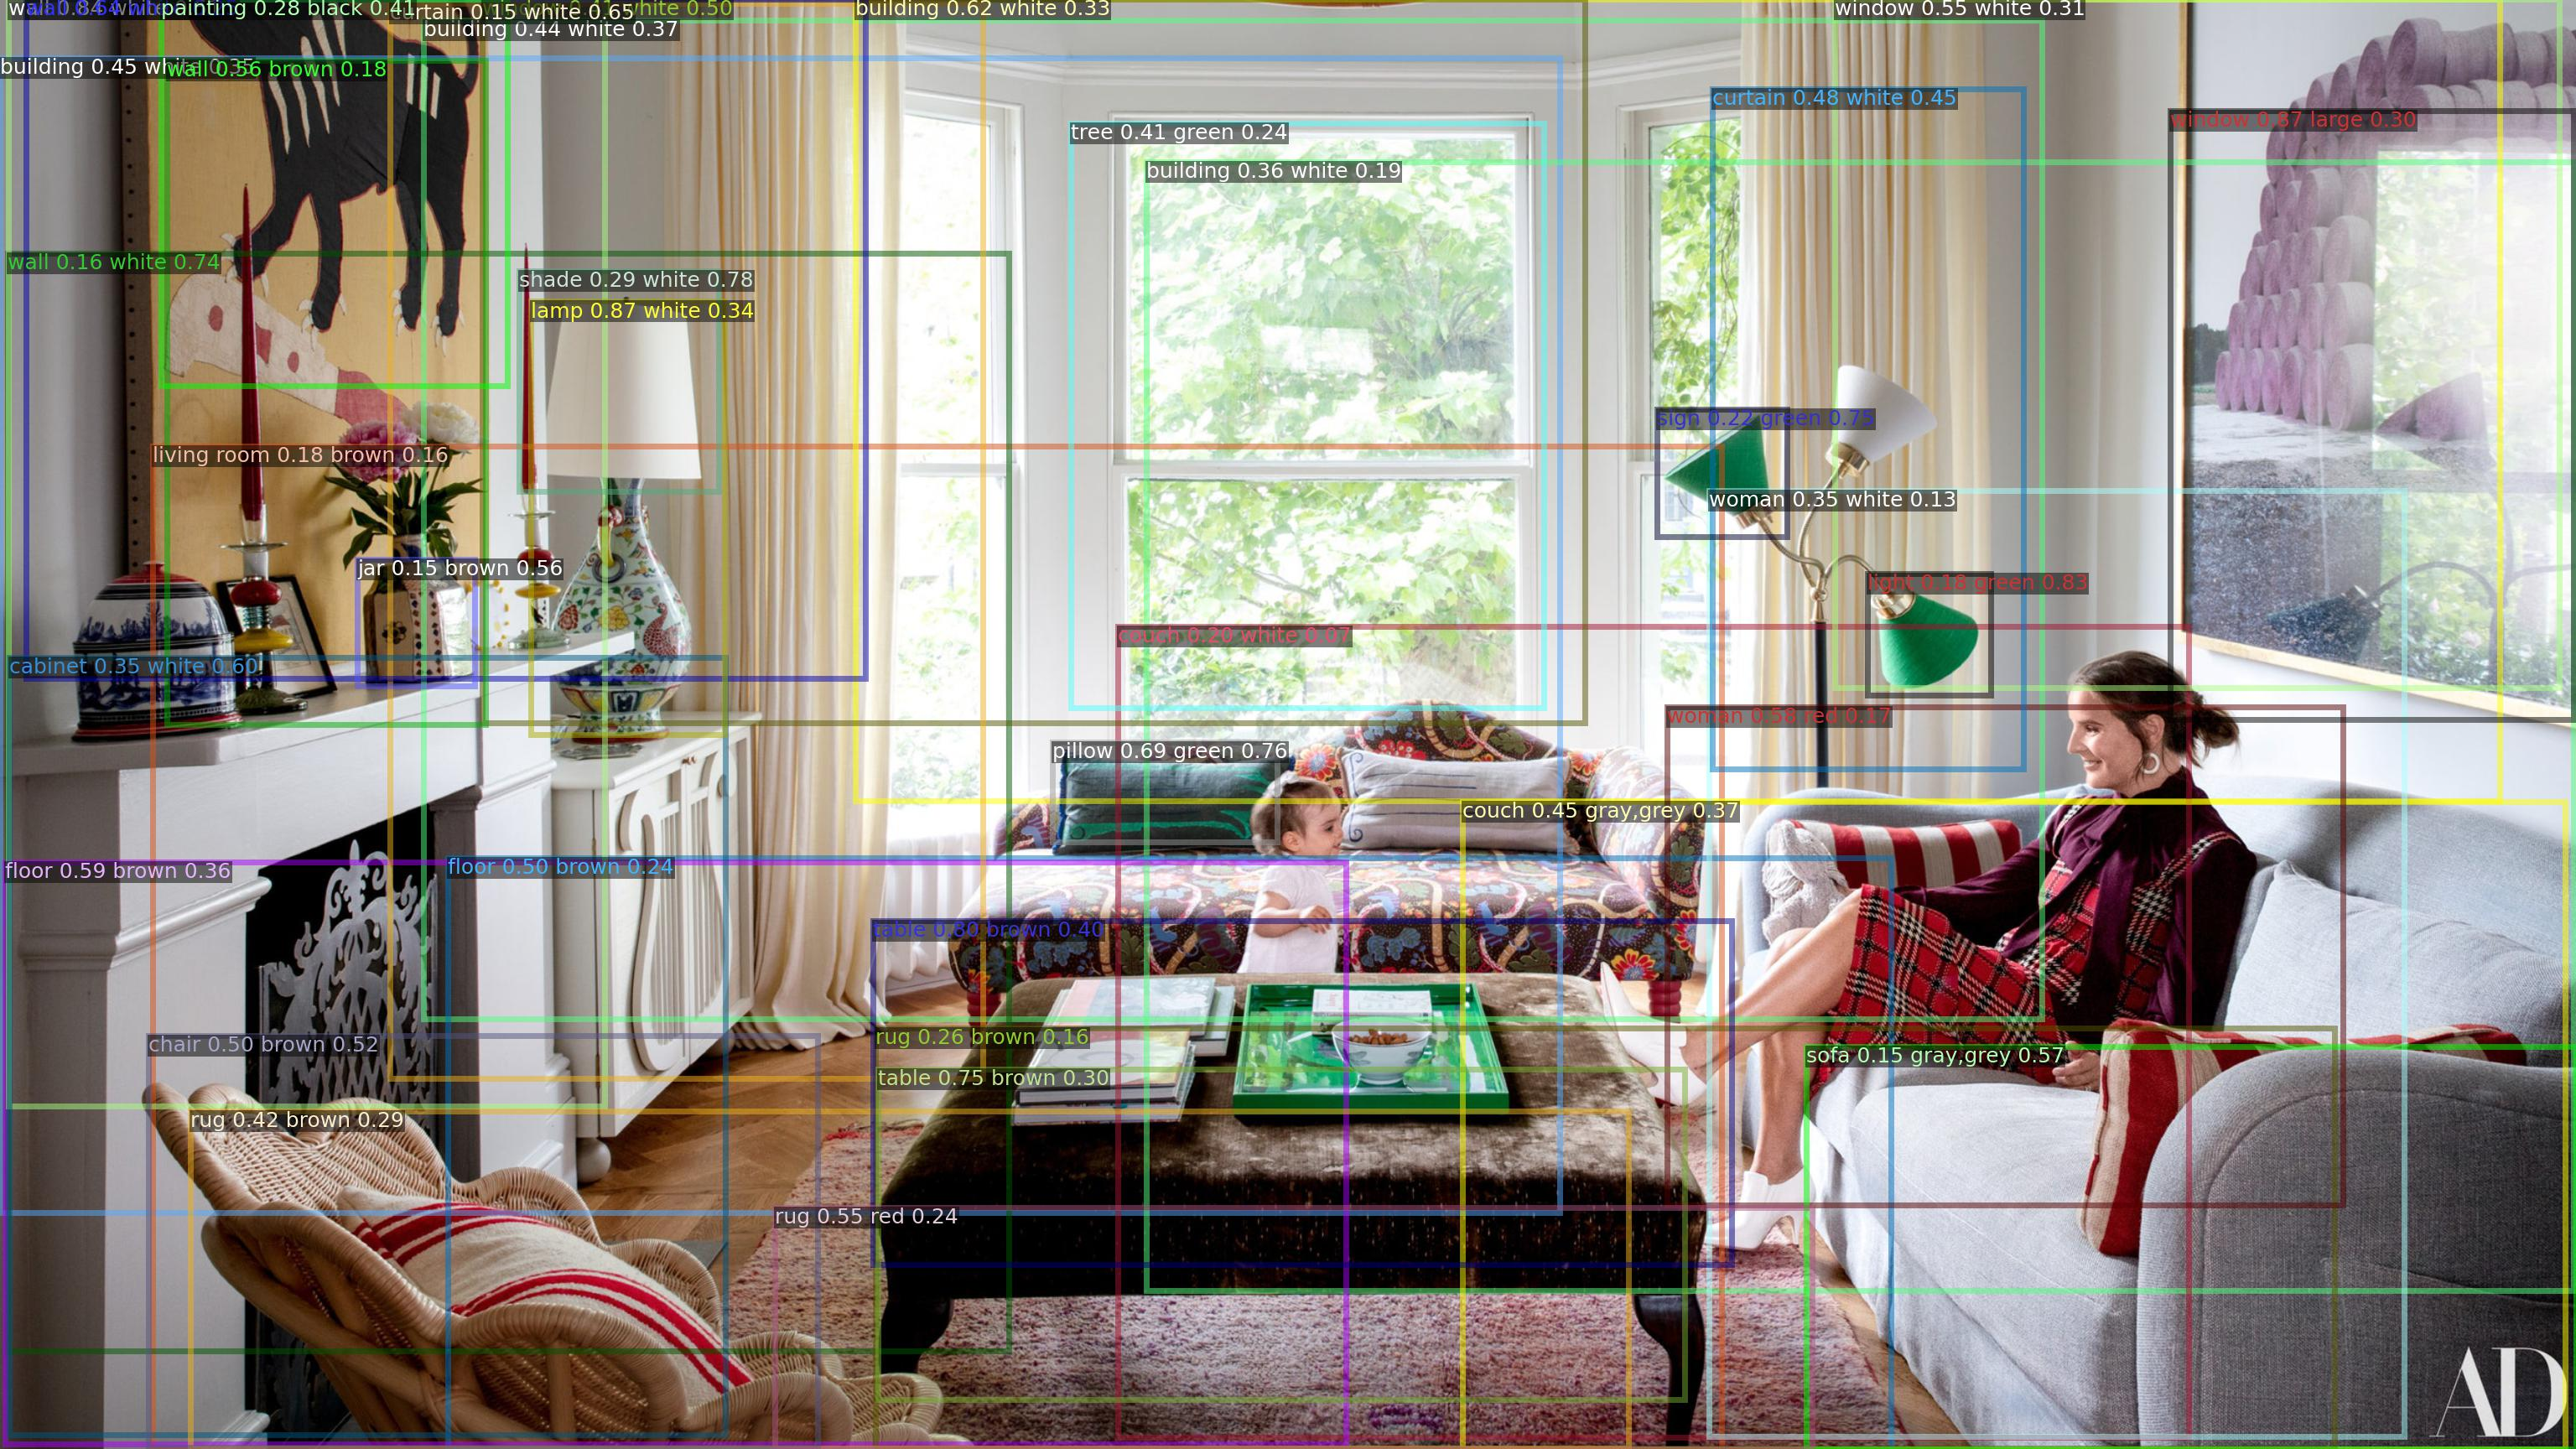

In [69]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))  # np.unit8(): 양수, 0-255, np.clip(): array 내 원소가 범위 외의 크기이면 범위값으로 바꿔줌
    f = io.BytesIO() # 바이너리 I/O, bytes 객체 생성. 텍스트가 아닌 데이터에 사용
    PIL.Image.fromarray(a).save(f, fmt) # numpy 배열을 PIL 이미지로 변환
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [70]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [76]:
# Huggingface에서 제공하는 LXMERT의 tokenizer 생성
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [77]:
inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [78]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the woman?']
prediction from LXMERT VQA: couch
Question: ['What is near the table?']
prediction from LXMERT VQA: basket
Question: ['What is the color of the lamp?']
prediction from LXMERT VQA: green
Question: ['What is the shape of the window?']
prediction from LXMERT VQA: round
Question: ['What is the color of the curtain?']
prediction from LXMERT VQA: white
Question: ['What is the baby doing?']
prediction from LXMERT VQA: sitting
Question: ['Where is the jar?']
prediction from LXMERT VQA: table


In [79]:
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['Where is the woman?']
prediction from LXMERT VQA: living room
Question: ['What is near the table?']
prediction from LXMERT VQA: chair
Question: ['What is the color of the lamp?']
prediction from LXMERT VQA: green
Question: ['What is the shape of the window?']
prediction from LXMERT VQA: square
Question: ['What is the color of the curtain?']
prediction from LXMERT VQA: white
Question: ['What is the baby doing?']
prediction from LXMERT VQA: sitting
Question: ['Where is the jar?']
prediction from LXMERT VQA: coffee table


### VQA와 GQA 비교
주어진 이미지로 해보았을 때는 VQA가 보다 정확한 답변을 하였다. 예를 들어 'What is near the disk?'라는 질문에서 VQA는 'cat', GQA는 'can'으로 대답하였고, 'What is the color of the cat?'의 질문에는 VQA는 'black and white', GQA는 'black'으로 대답하였다. 

그러나 내가 선택한 이미지의 경우는 어느 것이 정확하다고 판단하기 어렵다. 'Where is the woman?'라는 질문에는 VQA가 'couch'로 대답하여 GQA의 'living room'보다는 구체적으로 대답하였으나, 'What is near the table?'에는 VQA는 존재하지 않는 'basket'으로 대답하였고, 'What is the shape of the window?'라는 질문에는 'round'라고 잘못된 대답을 했다. 동작을 질문하는 질문에는 두 개 모두 'sitting'이라는 잘못된 대답을 하고 있다. 

정리하자면, VQA가 GQA보다 더 구체적인 답을 하고, VQA와 GQA 모두 잘못된 대답을 하는 경우가 있다. 

## 루브릭

|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. LXMERT 모델을 활용해 새로운 이미지에 대한 VQA 작업을 진행하였다.|이미지 bounding box 시각화 및 question에 대한 answer 출력이 정상적으로 진행되었다.|Y     |
|2. GQA 버전의 LXMERT 모델을 활용해 VQA 작업을 진행하였다.|GQA 버전 모델을 활용하여 question에 대한 answer 출력이 정상적으로 진행되었다.|Y|
|3. VQA, GQA 버전의 성능을 체계적으로 비교분석하였다.|자신이 선택한 다양한 이미지에 대해 두 모델의 답안이 어떻게 달라지는지 비교분석 결과를 제출하였다.| Y  |

## 후기
### 이번 프로젝트에서 어려웠던 점
- LXMERT 모델의 구조를 이해하는 것이 어려웠다.

### 프로젝트를 진행하면서 알게된 점
- LXMERT
- VQA, GQA

### 프로젝트를 진행하면서 아직 모호한 점
- 노드에서 설명해 놓은 코드 설명 부분이 이해가 잘 안 된다. 

### 자기 다짐
모델을 이해하는 것이 어려웠지만 프로젝트는 노드를 그대로 갖다 쓰면 되기 때문에 어렵지는 않았다. 마지막 프로젝트를 끝냈는데도 아직 많이 부족한 것 같아서 아쉽다. 앞으로 어떻게 공부해야 할지, 어디에 집중해야 할지 고민이 된다.